The idea here is to reproduce the MF+LHY critical atom number.

# import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# estimate_nc folder is ../../estimate_nc. Add it to the sys.path
import sys
sys.path.append('../../estimate_nc')
from estimate_nc import get_optimal_sr_sz, en_per_particle
sys.path.append('../egpe')
from egpe import eGPE


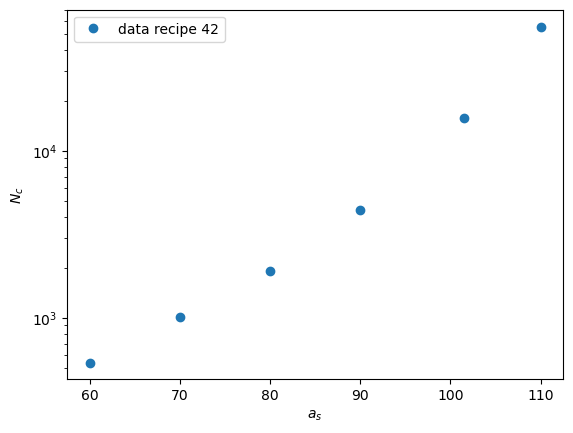

In [2]:
#   load data from ../../results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat
data = np.loadtxt('../../results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat')
a_s_arr = data[:,0]
n_c_arr = data[:,1]

# plot data
plt.plot(a_s_arr, n_c_arr, 'o', label='data recipe 42')

# set log scale
plt.yscale('log')

# set axis labels
plt.xlabel(r'$a_s$')
plt.ylabel(r'$N_c$')

# set legend
plt.legend()

# Example

Explore how much the values of sr and sz change when the number of atoms is changed.

In [3]:
# # set an eGPE object with a_s = 90, nparticles = 3*10**5, and include_ho = False.

# for a_s, n_c in zip(a_s_arr, n_c_arr):
    
#     print("------------------")
#     print(a_s)
    
#     # set nparticles
#     nparticles = 2 * n_c

#     # Initialize the eGPE object
#     gp = eGPE(a_s=a_s, nparticles=nparticles)

#     # get alpha, beta, gamma
#     alpha, beta, gamma = gp.alpha_mflhy, gp.beta_mflhy, gp.gamma_mflhy
#     print(f"alpha: {alpha}, beta: {beta}, gamma: {gamma}")
    
#     # Get the optimal sr and sz
#     opt_params = get_optimal_sr_sz(alpha, beta, gamma, nparticles)
#     sr_start, sz_start, en_0 = opt_params["sr"], opt_params["sz"], opt_params["en_0"]

#     # print the sr and sz values for the local minima
#     print(f"a_s: {a_s}, nparticles: {nparticles}, sr_start: {sr_start}, sz_start: {sz_start}, en_0: {en_0}")
    
#     # Set the box size and the number of grid points, and update the grid parameters
#     gp.set_box_size(np.array([sr_start, sr_start, sz_start]) * 40)
#     gp.set_nxyz([64]*3)
#     gp.update_grid_params()
    
#     # Setting the gaussian wavefunction and normalizing it
#     gp.set_gaussian_psi(sr_start, sz_start)
#     gp.normalize_psi()

#     # Calculate the energy and print it
#     energy_contributions = gp.energy_contributions()
#     print(energy_contributions, sum(energy_contributions.values()) / gp.nparticles )
    


They don't change that much, so you can use the later values.

# Get critical atom number from 3D eGPE

In [4]:
# set an eGPE object with a_s = 90, nparticles = 3*10**5, and include_ho = False.

for a_s, n_c in zip(a_s_arr, n_c_arr):
    
    print(a_s)
    print("------------------")
    
    # set nparticles
    nparticles = 2 * n_c
    
    # Initialize the eGPE object
    gp = eGPE(a_s=a_s, 
              nparticles=nparticles, 
              nxyz=[32]*3,
              contact_interaction=True,
              dipolar_interaction=True)

    # get alpha, beta, gamma
    alpha, beta, gamma = gp.alpha_mflhy, gp.beta_mflhy, gp.gamma_mflhy

    # Get the optimal sr and sz
    opt_params = get_optimal_sr_sz(alpha, beta, gamma, nparticles)
    sr_start, sz_start, en_0 = opt_params["sr"], opt_params["sz"], opt_params["en_0"]
    
    # Print the initial parameters
    print(f"a_s: {a_s}, nparticles: {nparticles}, sr_start: {sr_start}, sz_start: {sz_start}, en_0: {en_0}")
    
    # Set box_size
    gp.set_box_size(np.array([sr_start, sr_start, sz_start]) * 20)
    gp.rho_cutoff=0.8,
    gp.z_cutoff=0.8
    gp.update_grid_params()
    
    gp.set_gaussian_psi(sr_start, sz_start)
    # normalize the wavefunction
    gp.normalize_psi()
    
    nparticles_start = nparticles
    while nparticles_start > 0.5*n_c:
        print(f"a_s={a_s}, nparticles_start={nparticles_start}")
        gp.nparticles = nparticles_start
        
        # Starting the 3D minimization
        print("Starting the 3D minimization")
        
        gp.set_gaussian_psi(sr_start, sz_start)
        # normalize the wavefunction
        gp.normalize_psi()
        
        energy_contributions = gp.energy_contributions()
        # print initial energy contributions
        print("Initial energy contributions:", energy_contributions, sum(energy_contributions.values()))
        
        # Initialize the evolution
        dt = 100
        t_max = 1E+10
        gp.evolve(dt=dt, t_max=t_max, time_prop="imag", verbose=False) 
        
        
        # calculate <x>, <y>, <z> using get_avg_abs_x, get_avg_abs_y, get_avg_abs_z
        avg_abs_x = gp.get_avg_abs_x()
        avg_abs_y = gp.get_avg_abs_y()
        avg_abs_z = gp.get_avg_abs_z()
        
        # Calculate the energy contributions
        energy_contributions = gp.energy_contributions()
        # get the total energy
        energy = sum(energy_contributions.values())
        
        # Print avg_abs_x/sr_start, avg_abs_y/sr_start, avg_abs_z/sz_start, energy
        print("avg_abs_x/sr_start: ", avg_abs_x/sr_start)
        print("avg_abs_y/sr_start: ", avg_abs_y/sr_start)
        print("avg_abs_z/sz_start: ", avg_abs_z/sz_start)
        print("energy: ", energy)
        
        
        # The while loop breaks when avg_abs_x / sr_start > 100 or avg_abs_y / sr_start > 100 or avg_abs_z / sz_start > 100
        if avg_abs_x / sr_start > 100 or avg_abs_y / sr_start > 100 or avg_abs_z / sz_start > 100:
            print("The while loop breaks when avg_abs_x / sr_start > 100 or avg_abs_y / sr_start > 100 or avg_abs_z / sz_start > 100")
            print("avg_abs_x / sr_start: ", avg_abs_x / sr_start)
            print("avg_abs_y / sr_start: ", avg_abs_y / sr_start)
            print("avg_abs_z / sz_start: ", avg_abs_z / sz_start)
            break
        
        nparticles_start = nparticles_start * 0.9
        
        
        

        

110.0
------------------
Calculating integral part of dipolar potential...


100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


[INFO] Initializing psi
a_s: 110.0, nparticles: 111181.2, sr_start: 74.30861723446894, sz_start: 1484.0, en_0: -2.9937830630518843e-05
Calculating integral part of dipolar potential...


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


a_s=110.0, nparticles_start=111181.2
Starting the 3D minimization
Initial energy contributions: {'kinetic': 10.080152901094086, 'pot_ext': 2.866884237262992e-20, 'pot_int': -7.333934337594424} 2.7462185634996628


  0%|          | 4000/100000000 [00:33<230:32:00, 120.49it/s]


Total energy converged
avg_abs_x/sr_start:  0.5963380509292545
avg_abs_y/sr_start:  0.5963380509292546
avg_abs_z/sz_start:  0.7102569457910575
energy:  1.4730316363067129
a_s=110.0, nparticles_start=100063.08
Starting the 3D minimization
Initial energy contributions: {'kinetic': 9.072137610984681, 'pot_ext': 2.580195813536693e-20, 'pot_int': -6.496868939212164} 2.575268671772517


  0%|          | 12566/100000000 [01:43<228:29:35, 121.55it/s]


KeyboardInterrupt: 